## Epidemic-Behavior Interaction Model (EBIM)

[🔗 Notion Page](https://shengfu.notion.site/Epidemic-Behavior-Interaction-Model-EBIM-e456583642254fae92007c80f4944587?pvs=4)

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class Node: 

    def __init__(self, node_id, zeta) -> None:
        """
        Initialize a Node with an ID and initial state.
        
        Args:
        - node_id (int): Unique identifier for the node.
        - state_awareness (int): 0 for unaware (U), 1 for aware (A).
        - state_disease (int): 0 for susceptible (S), 1 for infected (I).
        """

        self.id = node_id
        self.state_disease = 0
        self.state_awareness = 0

        self.new_state_disease = 0
        self.new_state_awareness = 0

        self.physical_neighbors = []
        self.virtual_neighbors = []

        # set aware therold as a random number between 0 and 1 following a uniform distribution
        self.aware_therold = np.random.uniform(0, 1)

        self.infected_time = -1
        self.aware_time = -1
        self.swith_to_unaware_time = -1

        self.zeta = zeta

    def add_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.append(neighbor_node)
    
    def remove_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.remove(neighbor_node)

    def add_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.append(neighbor_node)

    def remove_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.remove(neighbor_node)

    def get_physical_neighbors_id(self):
        return [neighbors.id for neighbors in self.physical_neighbors]

    def get_virtual_neighbors_id(self):
        return [neighbors.id for neighbors in self.virtual_neighbors]

    def turn_into_aware(self, time: int):
        self.new_state_awareness = 1
        self.aware_time = time
        self.swith_to_unaware_time = time + np.random.exponential(1 / self.zeta) # awareness switches from 1 to 0 following the exponential distribution with the rate the rate parameter zeta. 

    def turn_into_unaware(self):
        self.new_state_awareness = 0
        self.aware_time = -1
        
    def turn_into_infectious(self, time: int):
        self.new_state_disease = 1
        self.infected_time = time

        # self.turn_into_aware(time) # If the node is infected, then turn into aware???

    def turn_into_susceptible(self):
        self.new_state_disease = 0
        self.infected_time = -1

    def update_to_new_state(self):
        self.state_disease = self.new_state_disease
        self.state_awareness = self.new_state_awareness


class TwoLayerNetwork:
    def __init__(self, N, beta_a, beta_u, infection_period, gamma, zeta, p=0.1, rewiring_percentage=0.5, initial_infected_ratio = 0.05, intial_aware_ratio = 0.01) -> None:
        """
        Initialize a two-layer network with N nodes in each layer.

        Args:
        - N (int): Number of nodes in each layer.
        - rewiring_percentage (float): Percentage of edges to rewire in the virtual network
        - beta_a (float): Transmission probability for aware nodes.
        - beta_u (float): Transmission probability for unaware nodes.
        """
        # Create N nodes 
        self.nodes = [Node(node_id=i, zeta=zeta) for i in range(N)]

        # Infect a fraction of the nodes
        num_infected = int(initial_infected_ratio * N)
        infected_nodes = np.random.choice(self.nodes, num_infected, replace=False)
        for node in infected_nodes:
            node.turn_into_infectious(time=0)
        
        # Make a fraction of the nodes aware
        num_aware = int(intial_aware_ratio * N)
        aware_nodes = np.random.choice(self.nodes, num_aware, replace=False)
        for node in aware_nodes:
            node.turn_into_aware(time=0)

        for node in self.nodes:
            node.update_to_new_state()

        # Create the physical network
        G = nx.erdos_renyi_graph(n=N, p=p)
        self.create_physical_network(G)

        # Rewire the network by performing double edge swaps
        num_swaps = int(rewiring_percentage * G.number_of_edges())
        nx.connected_double_edge_swap(G, nswap=num_swaps)
        self.create_virtual_network(G)

        # Set the parameters of the model
        self.beta_a = beta_a
        self.beta_u = beta_u
        self.infection_period = infection_period  
        self.gamma = gamma
        self.zeta = zeta

        self.round = 0

    def create_physical_network(self, G):
        """
        Create the physical network by adding physical neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the physical network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_physical_neighbor(self.nodes[neighbor])
    
    def create_virtual_network(self, G):
        """
        Create the virtual network by adding virtual neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the virtual network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_virtual_neighbor(self.nodes[neighbor])
    
    def update_health_state(self):
        """
        Update the health state of each node in the network.
        """
        for node in self.nodes:

            # If the node is susceptible: S -> I
            if node.state_disease == 0: 
                # 1. count the number of infected neighbors
                num_infected_neighbors = sum([neighbor.state_disease == 1 for neighbor in node.physical_neighbors])

                # 2. calculate the probability of transmission
                if node.state_awareness == 1:
                    transmission_prob = 1 - (1 - self.beta_a) ** num_infected_neighbors
                else:
                    transmission_prob = 1 - (1 - self.beta_u) ** num_infected_neighbors

                # 3. set the state of the node to infected with probability 'transmission_prob'
                if np.random.rand() < transmission_prob:
                    node.turn_into_infectious(time=self.round)

            # If the node is infected: I -> S
            elif node.state_disease == 1: 
                if self.round - node.infected_time >= self.infection_period: 
                    if np.random.rand() < self.gamma:
                        node.turn_into_susceptible()
    
    def update_awareness_state(self):
        """
        Update the awareness state of each node in the network.
        """
        global_infection_rate = self.count_infected() / len(self.nodes)

        for node in self.nodes:
            # If the node is unaware: U -> A
            if node.state_awareness == 0:
                # 1. count the proportion of aware neighbors
                proportion_aware_neighbors = sum([neighbor.state_awareness == 1 for neighbor in node.virtual_neighbors]) / len(node.virtual_neighbors) 

                # 2. decide the threshold for turning into aware
                threshold = (node.aware_therold * (1 - global_infection_rate)) * 2

                # 3. set the state of the node to aware if the threshold is met
                if proportion_aware_neighbors >= threshold:
                    node.turn_into_aware(time=self.round)

                # if node.id == 0:
                #     print(f"At time {self.round}, {node.id}: {proportion_aware_neighbors} vs. {threshold} = {node.aware_therold} * (1- {global_infection_rate})")
            
            # If the node is aware: A -> U
            if node.state_awareness == 1:
                if self.round >= node.swith_to_unaware_time:
                    node.turn_into_unaware()
                    # print(f"Node {node.id} turns into unaware at round {self.round}")
    
    def each_round(self):
        self.round += 1
        self.update_health_state()
        self.update_awareness_state()
        for node in self.nodes:
            node.update_to_new_state()

    def count_infected(self):
        return sum(node.state_disease == 1 for node in self.nodes)
    
    def count_aware(self):
        return sum(node.state_awareness == 1 for node in self.nodes)
    
    def get_network(self, layer):
        """
        Get the network of the specified layer.

        Args:
        - layer (str): "physical" or "virtual"
        """
        edge_list = []
        for node in self.nodes:
            if layer == "physical":
                for neighbor in node.physical_neighbors:
                    edge_list.append((node.id, neighbor.id))
        
            elif layer == "virtual":
                for neighbor in node.virtual_neighbors:
                    edge_list.append((node.id, neighbor.id))

        return nx.Graph(edge_list)

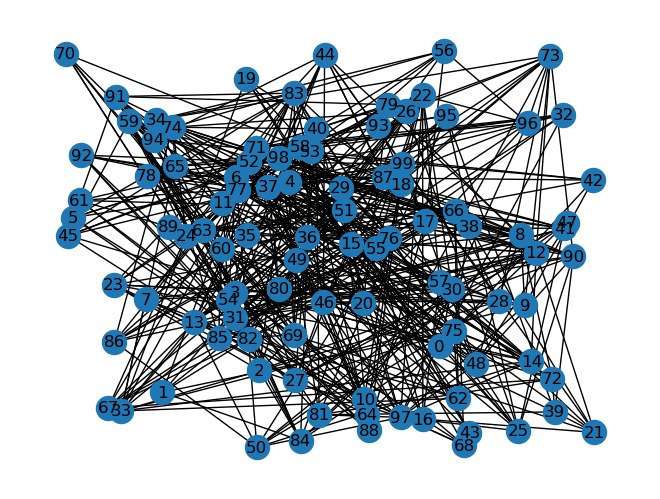

In [514]:
SISModel = TwoLayerNetwork(100, 0, 0, 0, 0, 1)

pos = nx.random_layout(SISModel.get_network("physical"), seed=123)
nx.draw(SISModel.get_network("physical"), pos=pos, with_labels = True)

In [515]:
np.random.seed(123)

N = 1000
beta_u = 0.01 # transmission probability for unaware nodes
beta_a = beta_u / 10 # transmission probability for aware nodes
infection_period = 10 # number of time steps before a node can recover
gamma = 0.6 # recovery probability 
zeta = 1/30 # rate parameter of switching from aware to unaware

SISModel = TwoLayerNetwork(N, beta_a, beta_u, infection_period, gamma, zeta, p=0.1, rewiring_percentage=0.3, initial_infected_ratio=0.05, intial_aware_ratio=0.01)

print(f"Physical network: {SISModel.get_network('physical').number_of_edges()} edges")
print(f"Virtual network: {SISModel.get_network('virtual').number_of_edges()} edges")
print(f"Infection number: {SISModel.count_infected()}")
print(f"Awareness number: {SISModel.count_aware()}")

# Step 5: Run the simulation over time
time_steps = 1000

infection_counts = [SISModel.count_infected()]
awreness_counts = [SISModel.count_aware()]
for t in range(time_steps):
    # Update the health state 
    SISModel.each_round()
    
    # Track the number of infected individuals
    infection_counts.append(SISModel.count_infected())
    awreness_counts.append(SISModel.count_aware())

Physical network: 50179 edges
Virtual network: 50179 edges
Infection number: 50
Awareness number: 10


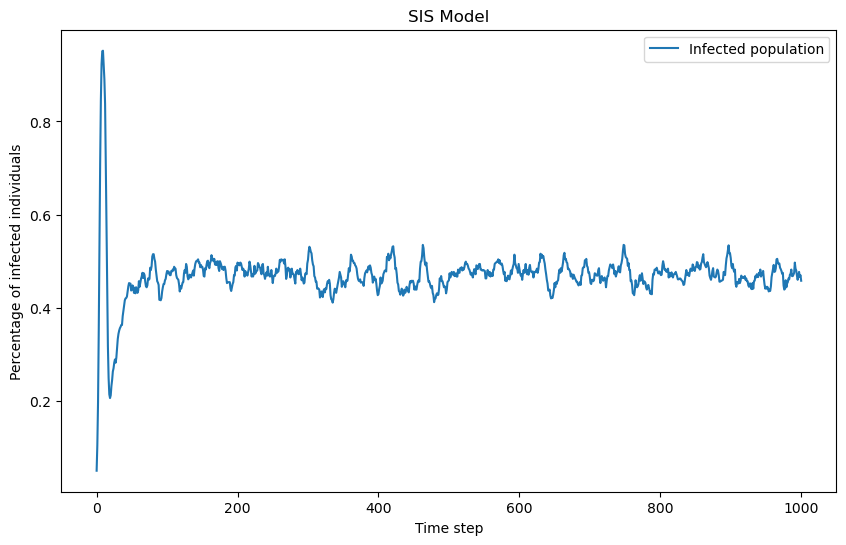

In [516]:
infection_proportion = np.array(infection_counts) / N

# Step 6: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps+1), infection_proportion, label='Infected population')
plt.xlabel('Time step')
plt.ylabel('Percentage of infected individuals')
plt.title('SIS Model')
plt.legend()
plt.show()

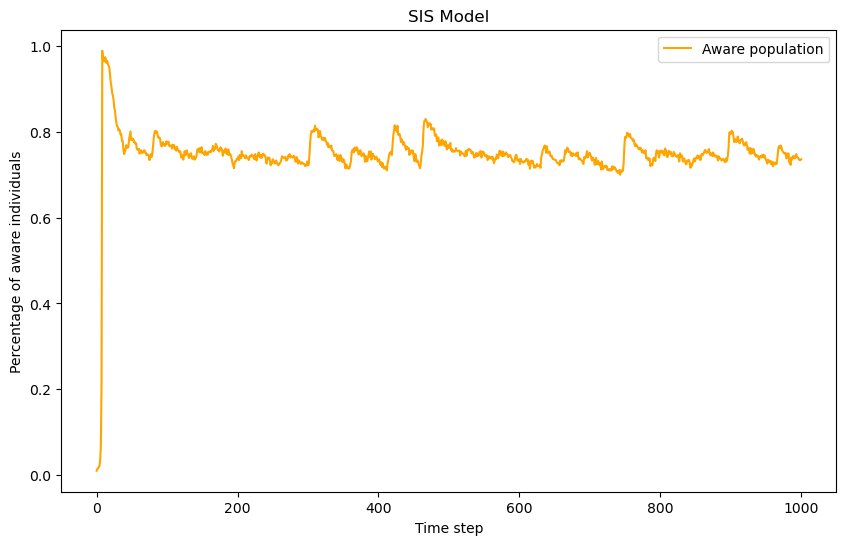

In [517]:
awreness_proportion = np.array(awreness_counts) / N

# Step 6: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps+1), awreness_proportion, label='Aware population', color='orange')
plt.xlabel('Time step')
plt.ylabel('Percentage of aware individuals')
plt.title('SIS Model')
plt.legend()
plt.show()